In [ ]:
import numpy as np
import random
np.random.seed(1)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

In [ ]:
class GeneticAlgorithm:
    
    def mutation(self,chromosome,chance):
        index_of_mutated = random.randint(0, len(chromosome) - 1)
        try_to_mutate = random.randint(0, 100)
        if try_to_mutate <= chance:
            if chromosome[index_of_mutated] == 0:
                chromosome[index_of_mutated] = 1
            else:
                chromosome[index_of_mutated] = 0
        return chromosome
    

    def random_chromosome(self,length):
        return np.random.randint(0, 2, length).tolist()
    
    def get_num_of_perc(self,chromosome,kind):
        if kind == 1:
            count = 0
            for i in range(0,int(len(chromosome)),2):
                count += 3 * chromosome[i]
        else:  
            count = 1
            for i in range(1,int(len(chromosome)),2):
                count += 0.25 * chromosome[i]  
        return int(count)

    def make_new_chromosomes(self,chr1,chr2):
        border = random.randint(1, len(chr2) - 1)
        child1 = []
        child2 = []
        for i in range(0,len(chr2)):
            if i < border:
                child1.append(chr1[i])
                child2.append(chr2[i])
            else:
                child1.append(chr2[i])
                child2.append(chr1[i])
        return child1,child2
    
    def fitness_function(self, fit_1):
        sum_of_good = np.sum(fit_1.history['accuracy'])
        return sum_of_good / len(fit_1.history['accuracy'])
    
    def roulette_wheel_selection(self,scores):
        suma = np.sum(scores)
        procents = [] 
        for i in range(0,len(scores)):
            procents.append(scores[i]/suma)
        arr_of_chance = []
        
        for i in range(0,len(scores)):
            for j in range(0,int(scores[i] * 100)):
                arr_of_chance.append(i)
        
        return random.choice(arr_of_chance)
    
    
    def make_new_popul(self,chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop):
        
        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 
        
        for i in range(n_pop):
            new_models_population.append(models.Sequential())
            new_models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))

        for i in range(0,int(n_pop/2)):
            first_index = self.roulette_wheel_selection(score)
            second_index = first_index
            while first_index  == second_index:
                second_index = self.roulette_wheel_selection(score)
                
            child1, child2 = self.make_new_chromosomes(chromosomes_population[first_index],chromosomes_population[second_index])
            
            child1 = self.mutation(child1,chance_mut)
            child2 = self.mutation(child2,chance_mut)

            new_chromosomes_population.append(child1)
            new_chromosomes_population.append(child2)


        for i in range(0,n_pop):

            num_of_filters = self.get_num_of_perc(chromosomes_population[i],1)
            shape_of_filter = self.get_num_of_perc(chromosomes_population[i],0)

            if num_of_filters != 0:
                new_models_population[i].add(layers.Conv2D(num_of_filters, (shape_of_filter, shape_of_filter), activation='relu', name='convolutional'))
            
            new_models_population[i].add(layers.MaxPooling2D((2, 2), name='max_pooling'))
            new_models_population[i].add(layers.Flatten(name='flatten'))
            new_models_population[i].add(layers.Dense(100, activation='relu', name='hidden'))
            new_models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            new_models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
            
            
            fit_1 = new_models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            new_score.append(self.fitness_function(fit_1))
        
        return new_chromosomes_population,new_score,new_models_population
    
    
    
    def genetic_algorithm(self,n_gens, n_iter, n_pop, chance_mut, X_train,y_train,val_stop,tb,X_test,y_test):
        
        best_score = 0
        count_steps = 0

        models_population = []
        chromosomes_population = []
        score = []



        new_models_population = []
        new_score = []
        new_chromosomes_population = [] 
        

        mean_on_popul = []
        best_in_popul = []

        for i in range(n_pop):
            models_population.append(models.Sequential())
            models_population[i].add(layers.InputLayer(input_shape=(8, 8, 1), name='input'))
        print(models_population)

        for i in range(0,n_pop):
            q = self.random_chromosome(n_gens)
            chromosomes_population.append(q)
        print(chromosomes_population)

        for i in range(0,n_pop):  

            num_of_filters = self.get_num_of_perc(chromosomes_population[i],1)
            shape_of_filter = self.get_num_of_perc(chromosomes_population[i],0)

            if num_of_filters != 0:
                models_population[i].add(layers.Conv2D(num_of_filters, (shape_of_filter, shape_of_filter), activation='relu', name='convolutional'))

            models_population[i].add(layers.MaxPooling2D((2, 2), name='max_pooling'))
            models_population[i].add(layers.Flatten(name='flatten'))
            models_population[i].add(layers.Dense(100, activation='relu', name='hidden'))
            models_population[i].add(layers.Dense(10, activation='softmax', name='output'))
            models_population[i].compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
          
            
            
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            fit_1 = models_population[i].fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))
            score.append(self.fitness_function(fit_1))
            
            
        print(models_population)
        print(score)


        print("start population")
        print(chromosomes_population)
        print("start score")
        print(score)
        print()


        mean_on_popul.append(np.sum(score)/len(score))
        best_in_popul.append(np.amax(np.array(score)))
        best_score = np.amax(np.array(score))

        for i in range(n_iter):
            new_chromosomes_population,new_score,new_models_population = self.make_new_popul(chromosomes_population,score,chance_mut, X_train,y_train,val_stop,tb,X_test,y_test,n_pop)
            
            print("population " + str(i))
            print(new_chromosomes_population)
            print("population scores " + str(i))
            print(new_score)
            print()


            if (np.sum(new_score)/10 - np.sum(score)/10 < -0.03) or (count_steps > 5):    
                print("population " + str(i))
                print(new_chromosomes_population)
                print("population scores " + str(i))
                print(new_score)
                print()

                models_population = new_models_population
                chromosomes_population = new_chromosomes_population
                score = new_score
                
                mean_on_popul.append(np.sum(score)/len(score))
                best_in_popul.append(np.amax(np.array(score)))
                
                self.show_learning(mean_on_popul,best_in_popul)
                return models_population, chromosomes_population, score   

            models_population = new_models_population
            chromosomes_population = new_chromosomes_population
            score = new_score

            mean_on_popul.append(np.sum(score)/len(score))
            best_in_popul.append(np.amax(np.array(score)))
            count_steps = +1

            if best_score < np.amax(np.array(score)):
                best_score = np.amax(np.array(score))
                count_steps = 0






        self.show_learning(mean_on_popul,best_in_popul)

        return models_population, chromosomes_population, score   



    def show_learning(self,mean_on_popul,best_in_popul):
        plt.figure(figsize=(8, 5))
        plt.plot(mean_on_popul, '-', label='mean_on_popul')
        plt.plot(best_in_popul, '-', label='best_in_popul')
        plt.xlabel("step of genetic algorithm")
        plt.legend()
        plt.show()
        

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
MinMaxScaler(copy=False).fit_transform(X)

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])

In [ ]:
X = X.reshape(X.shape[0], 8, 8, 1).astype('float32')

In [ ]:
y = to_categorical(y)
y.shape[0], y.shape[1], y

(1797, 10, array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32))

In [ ]:
X.dtype, X.shape, X.max(), y.shape

(dtype('float32'), (1797, 8, 8, 1), 1.0, (1797, 10))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=42)

%load_ext tensorboard

val_stop = EarlyStopping(monitor='val_loss', patience=5)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(logdir, histogram_freq=1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1347, 8, 8, 1), (450, 8, 8, 1), (1347, 10), (450, 10))

In [ ]:
gen = GeneticAlgorithm()

Выходные данные были обрезаны до нескольких последних строк (5000).
43/43 [==============================] - 0s 5ms/step - loss: 0.8625 - accuracy: 0.8916 - val_loss: 0.7185 - val_accuracy: 0.8644
Epoch 4/15
43/43 [==============================] - 0s 6ms/step - loss: 0.5590 - accuracy: 0.9154 - val_loss: 0.5308 - val_accuracy: 0.8578
Epoch 5/15
43/43 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.9220 - val_loss: 0.4207 - val_accuracy: 0.8933
Epoch 6/15
43/43 [==============================] - 0s 7ms/step - loss: 0.3162 - accuracy: 0.9295 - val_loss: 0.3796 - val_accuracy: 0.8844
Epoch 7/15
43/43 [==============================] - 0s 6ms/step - loss: 0.2592 - accuracy: 0.9495 - val_loss: 0.2660 - val_accuracy: 0.9289
Epoch 8/15
43/43 [==============================] - 0s 7ms/step - loss: 0.2165 - accuracy: 0.9473 - val_loss: 0.2714 - val_accuracy: 0.9222
Epoch 9/15
43/43 [==============================] - 0s 7ms/step - loss: 0.1902 - accuracy: 0.9540 - val

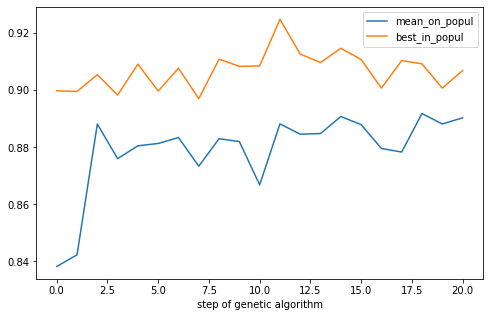

In [ ]:
models_population, chromosomes_population, score = gen.genetic_algorithm(20, 20, 10, 10, X_train,y_train,val_stop,tb,X_test,y_test)
# genetic_algorithm(self,n_gens, n_iter, n_pop, chance_mut, X_train,y_train,val_stop,tb,X_test,y_test)

In [ ]:
best_model = models_population[np.array(score).argmax(axis=0)] 

In [ ]:
fit_1 = best_model.fit(X_train, y_train, 
                    epochs=15, 
                    # batch_size=32,
                    callbacks=[val_stop, tb],
                    validation_data=(X_test, y_test))

Epoch 1/15
43/43 [==============================] - 0s 6ms/step - loss: 0.1062 - accuracy: 0.9725 - val_loss: 0.1615 - val_accuracy: 0.9467
Epoch 2/15
43/43 [==============================] - 0s 6ms/step - loss: 0.0951 - accuracy: 0.9748 - val_loss: 0.1567 - val_accuracy: 0.9578
Epoch 3/15
43/43 [==============================] - 0s 5ms/step - loss: 0.0872 - accuracy: 0.9792 - val_loss: 0.2211 - val_accuracy: 0.9311
Epoch 4/15
43/43 [==============================] - 0s 6ms/step - loss: 0.0831 - accuracy: 0.9800 - val_loss: 0.1829 - val_accuracy: 0.9333
Epoch 5/15
43/43 [==============================] - 0s 5ms/step - loss: 0.0749 - accuracy: 0.9814 - val_loss: 0.1680 - val_accuracy: 0.9533
Epoch 6/15
43/43 [==============================] - 0s 5ms/step - loss: 0.0679 - accuracy: 0.9837 - val_loss: 0.1432 - val_accuracy: 0.9556
Epoch 7/15
43/43 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.9837 - val_loss: 0.1306 - val_accuracy: 0.9556
Epoch 8/15
43/43 [==

In [ ]:
y_pred_1 = fit_1.model.predict(X_test)

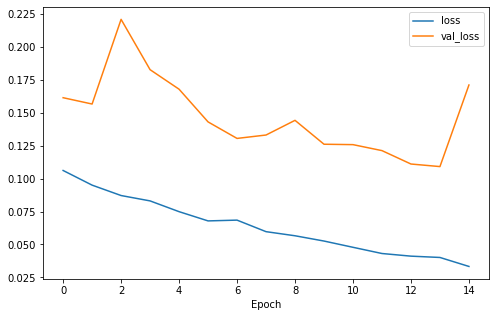

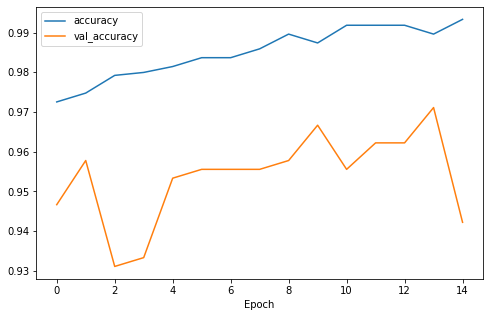

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['loss'], '-', label='loss')
plt.plot(fit_1.history['val_loss'], '-', label='val_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(fit_1.history['accuracy'], '-', label='accuracy')
plt.plot(fit_1.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

array([[44,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 43,  0,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 46,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 40,  0,  4,  0,  1,  0],
       [ 0,  0,  1,  0,  0, 44,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0, 43,  0,  0],
       [ 0,  2,  0,  1,  0,  0,  0,  0, 40,  0],
       [ 0,  1,  0,  8,  0,  1,  0,  0,  0, 35]])

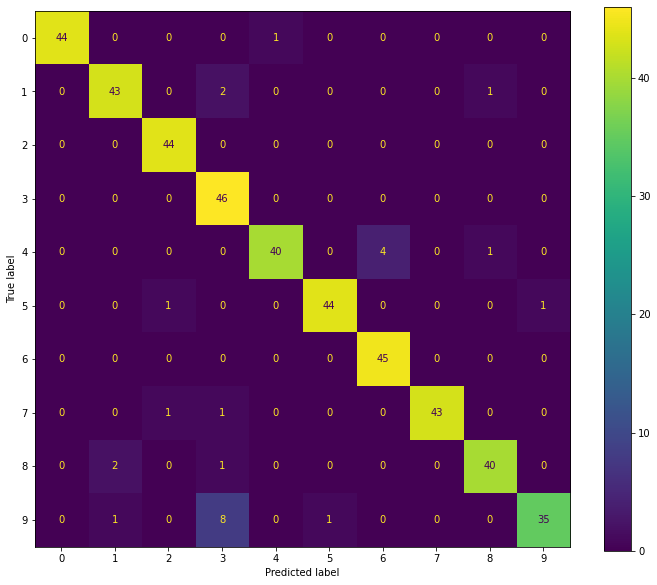

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(12, 10))
cmp.plot(ax=ax)
cm

In [ ]:
len(y_test)

450

In [ ]:
cm.sum()

450